In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
albums = pd.read_csv('../data/raw/albums.csv',encoding='utf-8',index_col=0)
albums.head(1)

,artist,average rating,compilation,countries of versions,country,format,format details,genre,highest price sold,label,...,number on label,number on label for sale,number want,release,style,title,track names,url,year,years of versions
0,Herbie Hancock,4.61,False,Europe; Yugoslavia; Canada; Japan; US,US,Vinyl,LP; Album,Electronic; Jazz,13.84,Columbia,...,104094,611795,3062,KC32731,Jazz-Funk,Head Hunters,Chameleon; Watermelon Man; Sly; Vein Melter,https://www.discogs.com/Herbie-Hancock-Head-Hu...,1973,1997; 1975; 1973; 2013; 1974


In [3]:
#Pick out only the albums that have been sold
print(str(len(albums)) +' total albums')
albums = albums[pd.notnull(albums['median price sold'])]
print(str(len(albums)) +' total sold albums')

25000 total albums
23124 total sold albums


We have a data set of 23124 values (for now) of the most popular jazz records on discogs. This won't be particularly representitive of all records, but can serve as a decent starting set for the model.

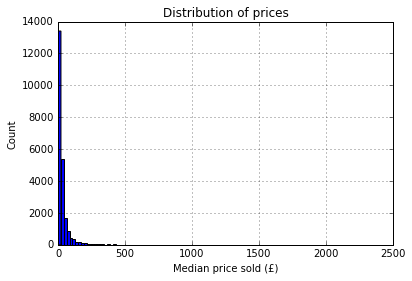

In [14]:
albums['median price sold'].hist(bins=100)
plt.xlabel('Median price sold (£)')
plt.ylabel('Count')
plt.title('Distribution of prices');

In [6]:
print('Mean sale price is £{0:.2f}'.format(albums['median price sold'].mean()))
print('Median sale price is £{0:.2f}'.format(albums['median price sold'].median()))

Mean sale price is £35.27
Median sale price is £18.45


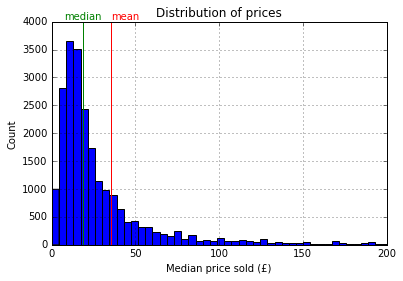

In [29]:
albums['median price sold'].hist(bins=500)
plt.xlabel('Median price sold (£)')
plt.xlim([0,200])
plt.ylabel('Count')
plt.title('Distribution of prices')
plt.plot([albums['median price sold'].mean(),albums['median price sold'].mean()],[0,4000],'-r')
plt.plot([albums['median price sold'].median(),albums['median price sold'].median()],[0,4000],'-g')
plt.text(albums['median price sold'].mean(),4000,'mean',color='r',ha='left',va='bottom')
plt.text(albums['median price sold'].median(),4000,'median',color='g',ha='center',va='bottom');

We have quite a few very expensive records which are shifting the mean higher.

If we use an R^2 cost function we find:

In [8]:
mean_cost = sum((albums['median price sold'] - albums['median price sold'].mean())**2)
median_cost = sum((albums['median price sold'] - albums['median price sold'].median())**2)
print('Total cost predicting mean sale price is {0:.2f}'.format(mean_cost))
print('Total cost predicting median sale price is {0:.2f}'.format(median_cost))

Total cost predicting mean sale price is 91553443.48
Total cost predicting median sale price is 98098370.88


Assuming the mean nevertheless proves a better method for generating predictions.

To measure the success of the model, let's look at two measures:  
1) The mean price difference between actual and predicted  
2) The R^2 score using the mean  
Both are defined below:

In [31]:
def get_mean_diff(y_test,y_pred):
    """Calculate the mean difference between test and prediction"""
    mean_diff = np.mean(abs(y_test - y_pred))
    return mean_diff

def get_score(y_test, y_pred):
    """Calculate the R^2 score from two numpy array inputs, using a guess of the median as a benchmark"""
    u = sum((y_test - y_pred)**2)
    v = sum((y_test - np.mean(y_test))**2)
    R_sq = 1 - u/v
    return R_sq

Let's see how these perform when we assume the mean for every value.

In [33]:
mean_diff = get_mean_diff(np.array(albums['median price sold']), albums['median price sold'].mean())
score = get_score(np.array(albums['median price sold']), albums['median price sold'].mean())
print('Guessing the mean gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

Guessing the mean gives £29.42 mean difference and 0.0000 score


## Building a regressor: Linear Regression

For each record sold we have the minimum sale price and the maximum sale price. These should provide a pretty good indicator of the price of the record.

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Use the most obvious predictors
predictors = ['lowest price sold', 'highest price sold']

#Do a linear regression
alg = LinearRegression()

#Split the data into 10 subsets
kf = KFold(new_albums.shape[0], n_folds = 10, random_state = 1)
predictions = []
scores = []

#Train and predict
for train, test in kf:
    X_train = (new_albums[predictors].iloc[train,:])
    y_train = new_albums['median price sold'].iloc[train]
    #Scale all the features
    scaler = StandardScaler().fit(X_train)
    X_train_transformed = scaler.transform(X_train)
    alg.fit(X_train_transformed, y_train)
    X_test = (new_albums[predictors].iloc[test,:])
    y_test = new_albums['median price sold'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)

predictions = np.concatenate(predictions,axis = 0)
#If anything is predicted a negative price, set this to zero
predictions[predictions<0] = 0
 
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)
print('Simple linear regression gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

Simple linear regression gives £5.38 mean difference and 0.9409 score


Of course this is kind of cheating: if the item has these two fields then it also has the median sale price as well,
so this model would be no use in predicting the prices of unsold items.

Let's leave out these fields for now, but keep these results as a benchmark for how well we may be able to perform.

In [35]:
albums.describe()

,average rating,compilation,highest price sold,lowest price for sale,lowest price sold,median price sold,number for sale,number have,number of ratings,number of tracks,number of versions,number on label,number on label for sale,number want
count,22470.000000,23124,23124.000000,19879.000000,23124.000000,23124.000000,23124.000000,23124.000000,23124.000000,23124.000000,23124.000000,23124.000000,23124.000000,23124.000000
mean,4.440929,0.0503373,53.495471,41.894874,23.455044,35.273678,7.726475,100.710647,13.932494,9.204290,18.103053,14223.290088,90367.772228,121.305440
std,0.435892,0.218645,83.212916,133.896217,55.123299,62.923845,11.678685,200.267372,22.786896,9.102978,32.195916,27328.508291,163528.201652,114.668566
min,1.000000,False,0.090000,0.010000,0.010000,0.090000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,45.000000
25%,4.200000,0,17.170000,8.570000,6.000000,11.220000,1.000000,20.000000,4.000000,6.000000,2.000000,125.000000,591.750000,61.000000
50%,4.500000,0,29.180000,16.270000,11.330000,18.450000,4.000000,46.000000,8.000000,8.000000,6.000000,1141.500000,6986.500000,85.000000
75%,4.750000,0,55.680000,34.405000,21.460000,34.610000,9.000000,107.000000,16.000000,11.000000,20.000000,10269.000000,50299.250000,136.000000
max,5.000000,True,2575.110000,8565.650000,2145.930000,2145.930000,189.000000,5684.000000,780.000000,889.000000,245.000000,198317.000000,616773.000000,3062.000000


From the numeric fields above let's pick out as features anything that may be expected to influence the price.

In [36]:
#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Use the following predictors
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want']

#Do a linear regression
alg = LinearRegression()

#Split the data into 10 subsets
kf = KFold(new_albums.shape[0], n_folds = 10, random_state = 1)
predictions = []
scores = []

#Train and predict
for train, test in kf:
    X_train = (new_albums[predictors].iloc[train,:])
    y_train = new_albums['median price sold'].iloc[train]
    #Scale all the features
    scaler = StandardScaler().fit(X_train)
    X_train_transformed = scaler.transform(X_train)
    alg.fit(X_train_transformed, y_train)
    X_test = (new_albums[predictors].iloc[test,:])
    y_test = new_albums['median price sold'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)

predictions = np.concatenate(predictions,axis = 0)
#If anything is predicted a negative price, set this to zero
predictions[predictions<0] = 0
 
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)
print('Simple linear regression gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

Simple linear regression gives £25.75 mean difference and 0.1330 score


Although not great, this is nevertheless an improvement on guessing the mean.

Let's see which features have the most effect (they've been scaled, so the relative size will correspond to their importance).

In [37]:
count = 0
for name in predictors:
    print('{0} coefficient is {1:.2f}'.format(name, alg.coef_[count]))
    count = count+1

compilation coefficient is -3.14
number for sale coefficient is -6.11
number have coefficient is -2.55
number of ratings coefficient is -8.64
number of tracks coefficient is 3.32
number of versions coefficient is -6.84
number on label coefficient is 6.54
number on label for sale coefficient is -7.91
number want coefficient is 19.71


So the most important factor is how many people want the album, as expected.  
However features like number of tracks seem to be more important than number of people who have the album. 
This is unexpected and may be the result of overfitting.

Let's regularise and see if we can reduce the variance and improve the score.

## Building a regressor: Ridge Regression

Use ridge to reglarise the linear regression, and see what effect this has on the predictions and coefficients.

In [38]:
from sklearn.linear_model import Ridge

#Use the following predictors
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want']

alpha_list = [0, 3, 5, 10, 30, 50, 100, 300, 500, 1000, 3000, 5000, 10000, 30000, 50000, 100000, 300000, 500000, 1000000]
mean_diff_list = []
score_list = []
coeff = {}

for alpha in alpha_list:
    
    #Randomly shuffle the row order
    new_albums = albums.sample(frac=1)
    
    #Do a ridge regression
    alg = Ridge(alpha=alpha)

    #Split the data into 10 subsets
    kf = KFold(new_albums.shape[0], n_folds = 10, random_state = 1)
    predictions = []
    scores = []

    #Train and predict
    for train, test in kf:
        X_train = (new_albums[predictors].iloc[train,:])
        y_train = new_albums['median price sold'].iloc[train]
        #Scale all the features
        scaler = StandardScaler().fit(X_train)
        X_train_transformed = scaler.transform(X_train)
        alg.fit(X_train_transformed, y_train)
        X_test = (new_albums[predictors].iloc[test,:])
        y_test = new_albums['median price sold'].iloc[test]
        test_predictions = alg.predict(scaler.transform(X_test))
        predictions.append(test_predictions)

    predictions = np.concatenate(predictions,axis = 0)
    #If anything is predicted a negative price, set this to zero
    predictions[predictions<0] = 0
 
    mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
    score = get_score(np.array(new_albums['median price sold']), predictions)
    
    mean_diff_list.append(mean_diff)
    score_list.append(score)
    coeff[alpha] = alg.coef_

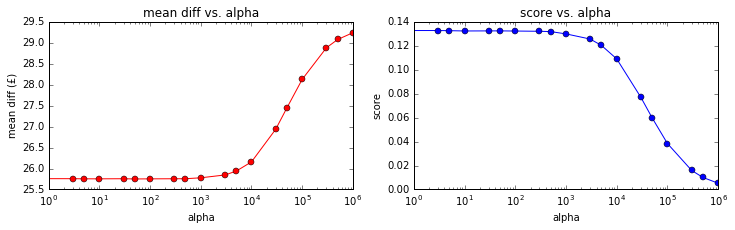

In [39]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(121)
ax1.plot(alpha_list,mean_diff_list,'-or')
ax1.set_title('mean diff vs. alpha')
ax1.set_xscale('log')
ax1.set_xlabel('alpha')
ax1.set_ylabel('mean diff (£)')
ax2 = fig.add_subplot(122)
ax2.plot(alpha_list,score_list,'-ob')
ax2.set_title('score vs. alpha')
ax2.set_xscale('log')
ax2.set_xlabel('alpha')
ax2.set_ylabel('score');

Regularisation makes little difference to the score until we start to excessively bias the predictor. Taking a value of alpha = 1000 gives:

In [42]:
print('Regularised linear regression with alpha = 100 gives £{0:.2f} mean difference and {1:.4f} score'
      .format(np.array(mean_diff_list)[np.array(alpha_list)==1000][0],
              np.array(score_list)[np.array(alpha_list)==1000][0]))

Regularised linear regression with alpha = 100 gives £25.78 mean difference and 0.1301 score


In [43]:
count = 0
for name in predictors:
    print('{0} coefficient is {1:.2f}'.format(name, coeff[1000][count]))
    count = count+1

compilation coefficient is -3.12
number for sale coefficient is -6.60
number have coefficient is -4.32
number of ratings coefficient is -4.87
number of tracks coefficient is 3.10
number of versions coefficient is -6.54
number on label coefficient is 4.15
number on label for sale coefficient is -5.59
number want coefficient is 17.04


This looks more as expected. The most important features are:  
1) The more people want the album, the higher the price  
2) The higher the number on sale, the lower the price  
3) The higher the number of versions of the album, the lower the price  
4) The higher the number on the label for sale, the lower the price 
5) The more people have the album, the lower the price

These are all measures, more or less, of the popularity and rarity of the record.

## Building a regressor: Random Forest Regression

Using all the initial features, let's see how well we can do with a more powerful algorithm - random forest regression.

In [44]:
from sklearn.ensemble import RandomForestRegressor

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Use the following predictors
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want']

#Do a random forest regression
alg = RandomForestRegressor()

#Split the data into 10 subsets
kf = KFold(new_albums.shape[0], n_folds = 10, random_state = 1)
predictions = []
scores = []

#Train and predict
for train, test in kf:
    X_train = (new_albums[predictors].iloc[train,:])
    y_train = new_albums['median price sold'].iloc[train]
    #Scale all the features
    scaler = StandardScaler().fit(X_train)
    X_train_transformed = scaler.transform(X_train)
    alg.fit(X_train_transformed, y_train)
    X_test = (new_albums[predictors].iloc[test,:])
    y_test = new_albums['median price sold'].iloc[test]
    test_predictions = alg.predict(scaler.transform(X_test))
    predictions.append(test_predictions)

predictions = np.concatenate(predictions,axis = 0)
#If anything is predicted a negative price, set this to zero
predictions[predictions<0] = 0
 
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)
print('Random forest regression gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

Random forest regression gives £21.13 mean difference and 0.2588 score


This is already quite a bit better than linear regression, but let's try to optimise further.

In [45]:
#Use the following predictors
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want']

#First optimise the minimum samples per leaf
min_samples_leaf_list = [1, 3, 5, 10, 30, 50, 100]
mean_diff_list = []
score_list = []

for min_samples_leaf in min_samples_leaf_list:
    
    #Randomly shuffle the row order
    new_albums = albums.sample(frac=1)
    
    #Do a ridge regression
    alg = RandomForestRegressor(min_samples_leaf = min_samples_leaf)

    #Split the data into 10 subsets
    kf = KFold(new_albums.shape[0], n_folds = 10, random_state = 1)
    predictions = []
    scores = []

    #Train and predict
    for train, test in kf:
        X_train = (new_albums[predictors].iloc[train,:])
        y_train = new_albums['median price sold'].iloc[train]
        #Scale all the features
        scaler = StandardScaler().fit(X_train)
        X_train_transformed = scaler.transform(X_train)
        alg.fit(X_train_transformed, y_train)
        X_test = (new_albums[predictors].iloc[test,:])
        y_test = new_albums['median price sold'].iloc[test]
        test_predictions = alg.predict(scaler.transform(X_test))
        predictions.append(test_predictions)

    predictions = np.concatenate(predictions,axis = 0)
    #If anything is predicted a negative price, set this to zero
    predictions[predictions<0] = 0
 
    mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
    score = get_score(np.array(new_albums['median price sold']), predictions)
    
    mean_diff_list.append(mean_diff)
    score_list.append(score)

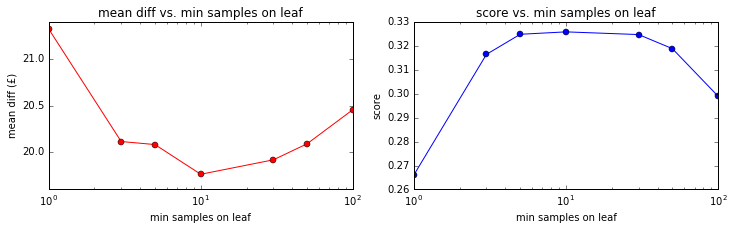

In [46]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(121)
ax1.plot(min_samples_leaf_list,mean_diff_list,'-or')
ax1.set_title('mean diff vs. min samples on leaf')
ax1.set_xscale('log')
ax1.set_xlabel('min samples on leaf')
ax1.set_ylabel('mean diff (£)')
ax2 = fig.add_subplot(122)
ax2.plot(min_samples_leaf_list,score_list,'-ob')
ax2.set_title('score vs. min samples on leaf')
ax2.set_xscale('log')
ax2.set_xlabel('min samples on leaf')
ax2.set_ylabel('score');

A minimum of 10 samples on each leaf seems to balance between excess bias and variance.

In [47]:
#Use the following predictors
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want']

#Secondly optimise the number of trees
n_estimators_list = [1, 3, 5, 10, 30, 50, 100]
mean_diff_list = []
score_list = []

for n_estimators in n_estimators_list:
    
    #Randomly shuffle the row order
    new_albums = albums.sample(frac=1)
    
    #Do a ridge regression
    alg = RandomForestRegressor(min_samples_leaf = 10, n_estimators = n_estimators)

    #Split the data into 10 subsets
    kf = KFold(new_albums.shape[0], n_folds = 10, random_state = 1)
    predictions = []
    scores = []

    #Train and predict
    for train, test in kf:
        X_train = (new_albums[predictors].iloc[train,:])
        y_train = new_albums['median price sold'].iloc[train]
        #Scale all the features
        scaler = StandardScaler().fit(X_train)
        X_train_transformed = scaler.transform(X_train)
        alg.fit(X_train_transformed, y_train)
        X_test = (new_albums[predictors].iloc[test,:])
        y_test = new_albums['median price sold'].iloc[test]
        test_predictions = alg.predict(scaler.transform(X_test))
        predictions.append(test_predictions)

    predictions = np.concatenate(predictions,axis = 0)
    #If anything is predicted a negative price, set this to zero
    predictions[predictions<0] = 0
 
    mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
    score = get_score(np.array(new_albums['median price sold']), predictions)
    
    mean_diff_list.append(mean_diff)
    score_list.append(score)

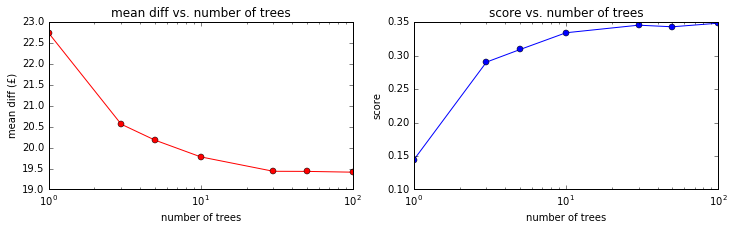

In [48]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(121)
ax1.plot(n_estimators_list,mean_diff_list,'-or')
ax1.set_title('mean diff vs. number of trees')
ax1.set_xscale('log')
ax1.set_xlabel('number of trees')
ax1.set_ylabel('mean diff (£)')
ax2 = fig.add_subplot(122)
ax2.plot(n_estimators_list,score_list,'-ob')
ax2.set_title('score vs. number of trees')
ax2.set_xscale('log')
ax2.set_xlabel('number of trees')
ax2.set_ylabel('score');

The more trees the better obviously, but 30 seems to be most of the way there.

In [50]:
print('Random forest regression with min_samples_leaf = 10 and n_estimators = 30 gives £{0:.2f} mean difference and {1:.4f} score'
      .format(np.array(mean_diff_list)[np.array(n_estimators_list)==30][0],
              np.array(score_list)[np.array(n_estimators_list)==30][0]))

Random forest regression with min_samples_leaf = 10 and n_estimators = 30 gives £19.43 mean difference and 0.3454 score


Let's use this random forest regressor as the prediction algorithm for evaluating new features.